In [341]:
import numpy as np
import pandas as pd
from graspy.utils import * 
from graspy.plot import heatmap, pairplot, gridplot
from graspy.embed import *
import seaborn as sns
import matplotlib.pyplot as plt
import re
import scipy
import networkx as nx
from pathlib import Path
from sklearn.utils.graph_shortest_path import graph_shortest_path
%matplotlib inline

In [5]:
basedir = Path('../../../eleGraSPy')
basedir = basedir / 'Cook et al revised Supplementary Information'
matdir = basedir / 'SI 5 Connectome adjacency matrices Pedigo.xlsx'
celldir = basedir / 'herm_cell_list_pedigo.xlsx'

In [6]:
def emmons_excel_to_df(matdir, sheet_name):
    df = pd.read_excel(matdir, sheet_name=sheet_name)
    # get the in / out cells
    # have to append some 0s to make into a square matrix
    outs = df.index.values
    ins = df.columns.values
    not_outs = np.setdiff1d(ins, outs)
    not_outs_df = pd.DataFrame(columns=df.columns)
    temp = np.empty((len(not_outs), len(ins)))
    temp[:] = 0
    not_outs_df = pd.DataFrame(temp)
    not_outs_df.columns = df.columns
    not_outs_df.index = not_outs
    df_full = pd.concat([df, not_outs_df])
    # reindex so that indices on matrices mean the same thing
    df_full = df_full.reindex(list(ins))
    return df_full

In [7]:
# get the excels as data frames, and add the missing values
herm_chem_df_full = emmons_excel_to_df(matdir, sheet_name=0)

In [42]:
#herm_chem_A_full = full adjacency matrix (453,453)
#herm_chem_A_self = Weighted adjacency matrix of lcc (446,446)
#herm_self_inds = matrix indices from input
herm_chem_A_self, herm_self_inds = get_lcc(herm_chem_A_full, return_inds=True)
#herm_cells = vertex anatomical labels
_, herm_cells = get_lcc(herm_chem_g, return_inds=True)

In [156]:
# get directed and undirected graphs 
g = nx.DiGraph()
herm_chem_g = nx.from_pandas_adjacency(herm_chem_df_full, create_using=g)
herm_chem_A_full = nx.to_numpy_array(herm_chem_g)

# Scott's cell metadata
cell_info = pd.read_excel(celldir, sheet_name=0)
cell_names = cell_info.index.values
cell_types1 = cell_info.loc[herm_cells, 'type1'].values
cell_types2 = cell_info.loc[herm_cells, 'type2'].values

In [186]:
#def get_subgraph(start_nodes,end_nodes,adj):
herm_chem_lcc = nx.from_numpy_matrix(herm_chem_A_self,create_using=nx.DiGraph)

In [307]:
endorgans_sex = [i for i,name in enumerate(herm_cells) for t1,t2 in cell_info[cell_info.index == name].values if t1 == 'endorgan' and 'sex' in t2]

In [313]:
sensors = [i for i,name in enumerate(herm_cells) for t1,t2 in cell_info[cell_info.index == name].values if t1 == 'sensory']

In [281]:
[herm_chem_lcc.edges[i,j] for i,j in herm_chem_lcc.in_edges(endorgans_sex[3])]

[{'weight': 30.0}]

In [323]:
def bfs(g,start_nodes,end_nodes=[],reverse=False):
    visited_inds = {n:(n in start_nodes)for n in g.nodes}
    queue = start_nodes.copy()
    while not len(queue) == 0:
        q = queue.pop(0)
        if q in end_nodes:
            continue
        if reverse:
            nodes = [i for i,_ in g.in_edges(q)]
        else:
            nodes = [i for _,i in g.out_edges(q)]
        for n in nodes:
            if visited_inds[n] == False:
                queue.append(n)
                visited_inds[n] = True
                
    inds = [i for i in visited_inds.keys() if visited_inds[i]==True]
    return(g.subgraph(inds),inds)

In [324]:
ff_g,ff_inds = bfs(herm_chem_lcc,sensors,end_nodes=endorgans_sex,reverse=False)

In [325]:
rf_g,rf_inds = bfs(herm_chem_lcc,endorgans_sex,end_nodes=sensors,reverse=True)

In [335]:
repro_inds = list(set(ff_inds).intersection(set(rf_inds)))
herm_chem_repro = herm_chem_lcc.subgraph(repro_inds)
herm_cells_repro = [name for i,name in enumerate(herm_cells) if i in repro_inds]

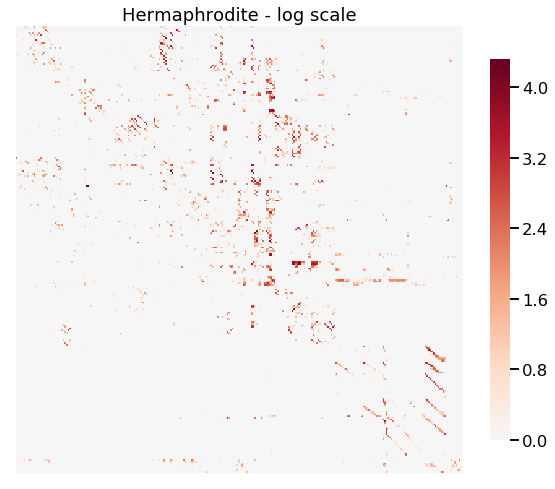

In [342]:
heatmap(herm_chem_repro,
        transform='log',
        title='Hermaphrodite - log scale')

In [357]:
end_organs = [i for i,name in enumerate(herm_cells) for t1,t2 in cell_info[cell_info.index == name].values if t1=='endorgan' and not t2=='neuron']